In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [6]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [7]:
@time D⁰ = assembleStiffnessMatrix(ctx, bdata=bdata)
@time D¹ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,0), bdata=bdata, on_torus=true)
K = 0.5(D⁰+D¹);
nothing

  0.461501 seconds (1.57 M allocations: 130.197 MiB, 4.34% gc time)
  8.916383 seconds (54.62 M allocations: 4.731 GiB, 12.05% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.25*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.808659 seconds (9.21 M allocations: 644.188 MiB, 3.08% gc time)


-1.1032835040942277

In [9]:
# assemble the linear response matrix L
@time L = adaptiveTOCollocationLinearResponseMatrix(ctx, T, 0, bdata=bdata, on_torus=true);

  8.261178 seconds (67.00 M allocations: 5.995 GiB, 8.77% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  1.147737 seconds (2.43 M allocations: 244.023 MiB)


-0.22283061209443275

In [11]:
# calculate the exact uϵ
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ),bdata=bdata, on_torus=true)
Kϵ = 0.5(D⁰+D¹ϵ);
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.25*grid_resolution*grid_resolution+0.5*grid_resolution))]<0
    uϵ = -uϵ
end
λϵ

-1.2485782760468194

In [12]:
λ₀ + ϵ*λ_dot

-1.214698810141444

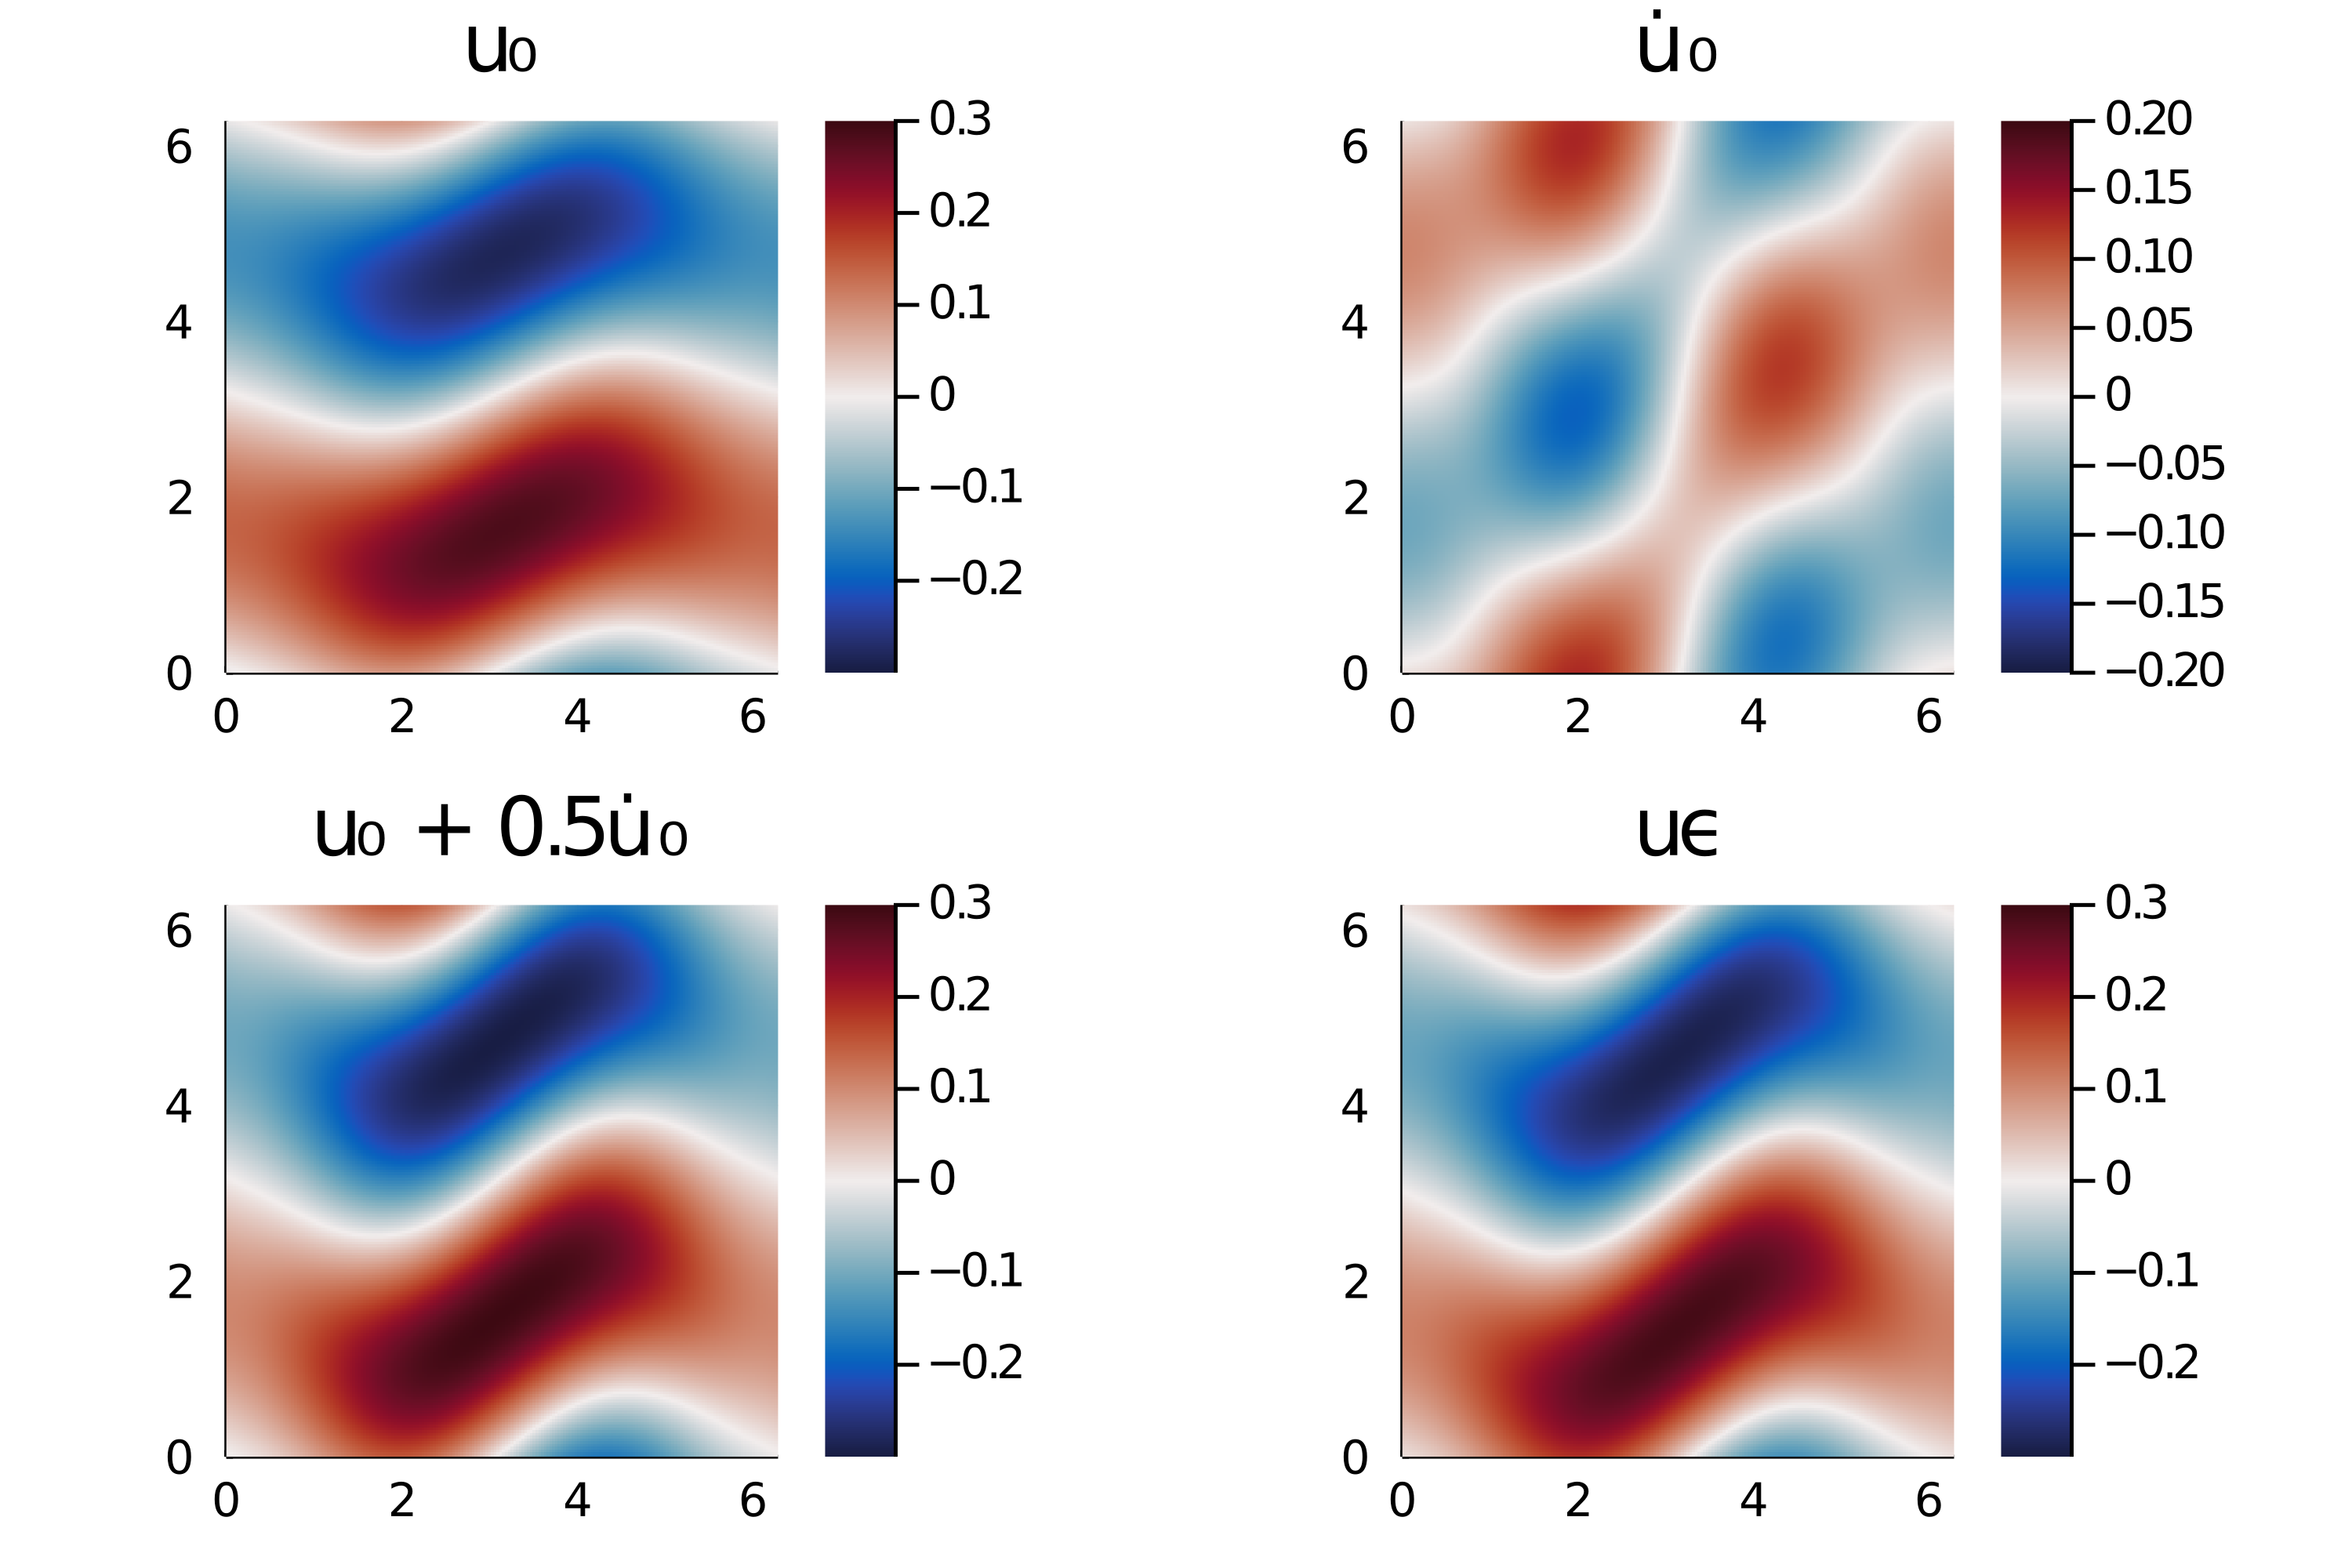

In [13]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [14]:
using Contour
using StaticArrays

In [15]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [16]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0003368254660866543
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0009063283387491516
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0014758312114117045
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0020453340840742573
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0026148369567367546
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0031843398293993075
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.003753842702061805
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004323345574724358
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0048928484473869105
└ @ Main In[16]:15
┌ Warning: C

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05273108975103946
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.053300592623702014
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05387009549636451
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.054439598369027065
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05500910124168962
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.055578604114352115
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05614810698701467
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.056717609859677165
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05728711273233972
└ @ Main In[16]:15
┌ Warning: Currently onl

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10512535403599227
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10569485690865482
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10626435978131737
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10683386265397987
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10740336552664242
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10797286839930492
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10854237127196747
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10911187414463003
└ @ Main In[16]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10968137701729253
└ @ Main In[16]:15
┌ Warning: Currently only co

Dynamic Cheeger value:	1.7985722882453223
Levelset:		0.20194084238862253


cheeger value		length			length transported	volume
2.0818522123692444	13.127930838505058	24.937632685249255	9.142234808405044
1.7985722882453223	9.133533463478601	8.004682735059735	4.7643946008025875


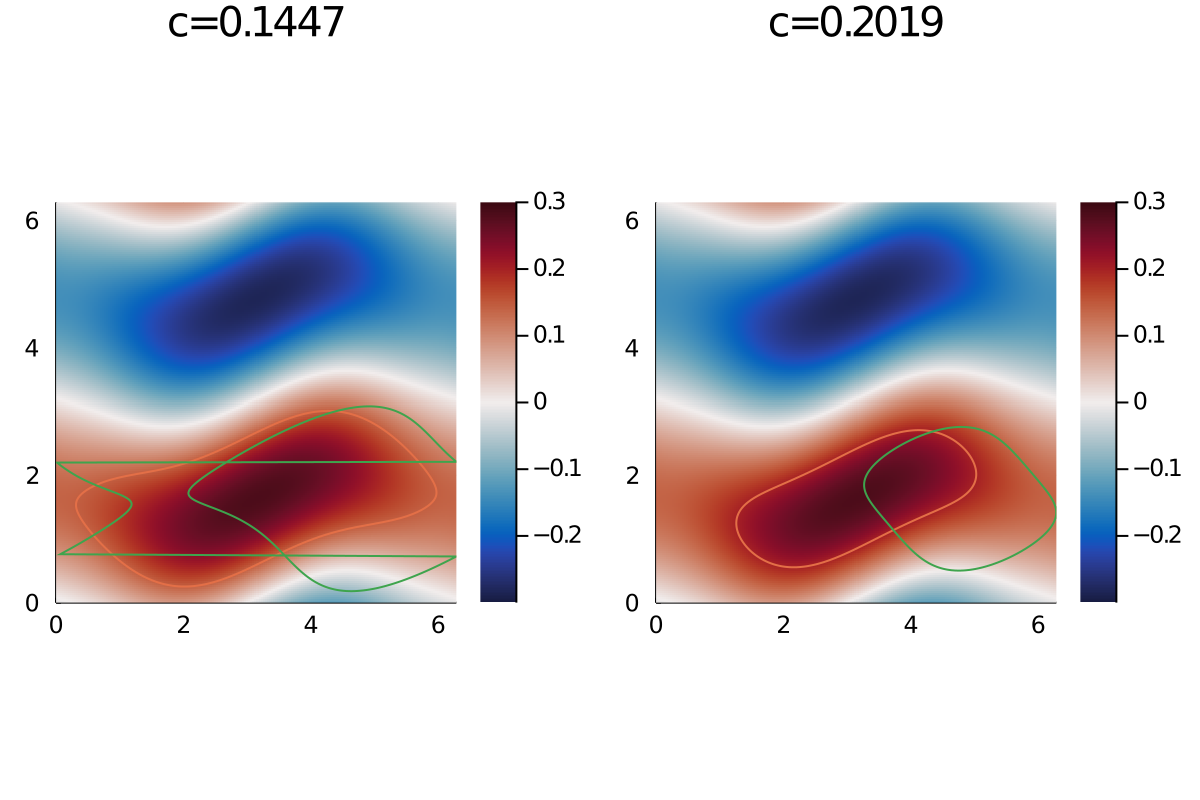

In [17]:
# value from paper
c_paper = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_ours, bdata=bdata))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot(plot_paper, plot_ours, fmt=:png,dpi=200)

In [18]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

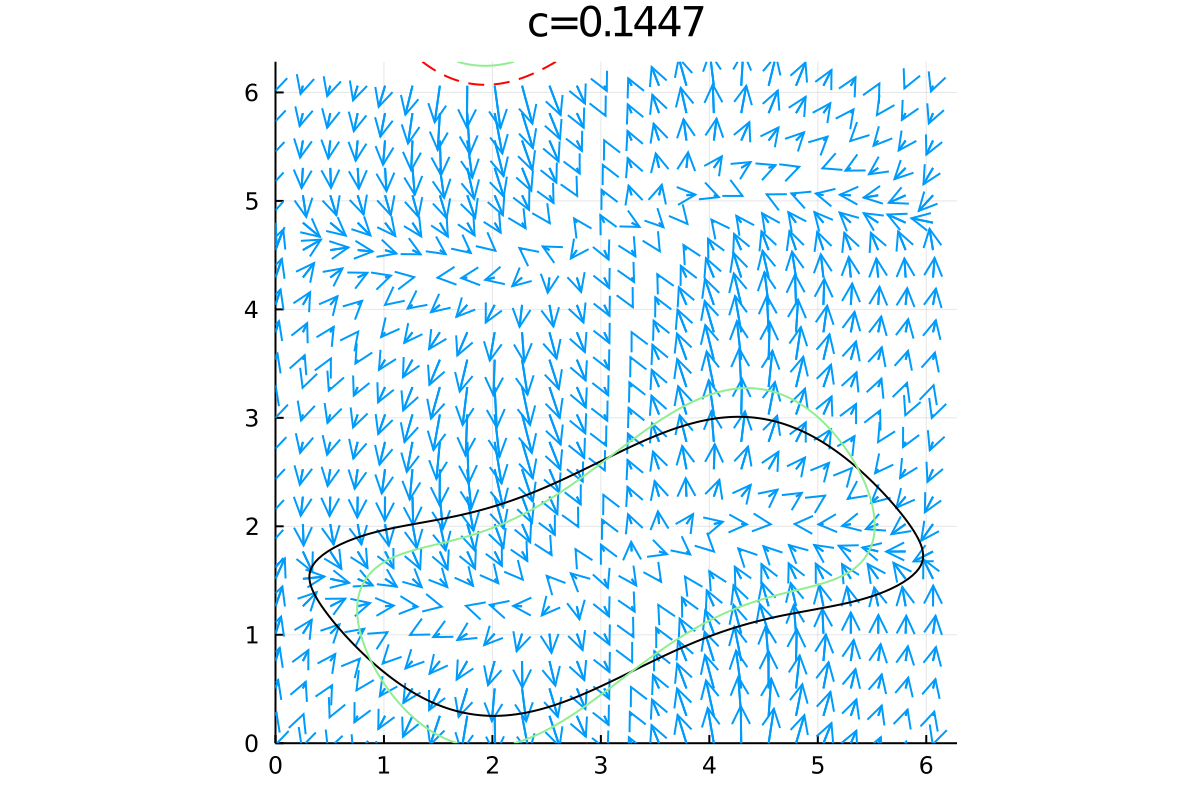

In [19]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot, bdata=bdata)...,scale=3,step=8)
curve         = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_epsilon = lines(get_levelset(ctx, uϵ, c_paper, bdata=bdata))[1]
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper, bdata=bdata))


plot!(coordinates(curve),color=:black)
plot!(coordinates(curve_epsilon),color=:red,linestyle=:dash)
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π),title="c=$(round(c_paper,digits=4))")